# Find and Run Missing HGB Setups

## Import modules

In [3]:
import openml
import json
import collections
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

# set api key
openml.config.apikey = open('.key', 'r').readline().strip('\n')

# set openml cache
# openml.config.cache_directory = os.path.expanduser('/scratch/hp2500/cache')

## Get evaluations

In [4]:
# get HGB evals
evals = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[12736], 
                                            output_format='dataframe')

evals.shape

(35708, 12)

In [6]:
evals

,run_id,task_id,setup_id,flow_id,flow_name,data_id,data_name,function,upload_time,value,values,array_data
0,10228527,3,8153751,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,3,kr-vs-kp,area_under_roc_curve,2019-06-16 02:10:23,0.999716,None,"[0.999716,0.999716]"
1,10228528,6,8153752,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,6,letter,area_under_roc_curve,2019-06-16 02:13:10,0.999721,None,"[0.999991,0.999518,0.999907,0.999763,0.999651,..."
2,10228529,11,8153753,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,11,balance-scale,area_under_roc_curve,2019-06-16 02:13:20,0.969933,None,"[0.981073,0.809914,0.986018]"
3,10228530,12,8153754,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,12,mfeat-factors,area_under_roc_curve,2019-06-16 02:16:32,0.998811,None,"[0.999819,0.999406,0.999814,0.996281,0.999669,..."
4,10228531,14,8153755,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,14,mfeat-fourier,area_under_roc_curve,2019-06-16 02:18:10,0.983606,None,"[0.999942,0.972461,0.996828,0.994172,0.983678,..."
5,10228532,15,8153756,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,15,breast-w,area_under_roc_curve,2019-06-16 02:18:17,0.991538,None,"[0.991538,0.991538]"
6,10228533,16,8153757,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,16,mfeat-karhunen,area_under_roc_curve,2019-06-16 02:19:40,0.998473,None,"[0.999492,0.999072,0.999886,0.997653,0.998789,..."
7,10228534,18,8153758,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,18,mfeat-morphological,area_under_roc_curve,2019-06-16 02:20:19,0.957119,None,"[0.999269,0.990742,0.954708,0.914918,0.962378,..."
8,10228535,22,8153759,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,22,mfeat-zernike,area_under_roc_curve,2019-06-16 02:21:49,0.965566,None,"[0.998497,0.997839,0.997542,0.991825,0.997575,..."
9,10228536,23,8153760,12736,sklearn.pipeline.Pipeline(simpleimputer=sklear...,23,cmc,area_under_roc_curve,2019-06-16 02:22:06,0.708021,None,"[0.733819,0.716229,0.670916]"


In [7]:
# drop runs with insufficient number of evals on CC-18
ids = (evals.setup_id.value_counts()).index[(evals.setup_id.value_counts() >= 72)]
evals_subset = evals[evals.setup_id.isin(ids)]

# transform to wide format
evals_wide = evals_subset.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

evals_wide.shape

(369, 71)

## Identify indices of missing runs

In [8]:
# empty list for indices of missing values
missing = []

for i in evals_wide.columns:
    for j in evals_wide.index:
        
        coordinates = (j, i)
        
        value = evals_wide.at[coordinates]

        if np.isnan(value):
            missing.append(coordinates)
            
len(missing)

671

In [9]:
missing = [k for k in missing if k[1] != 167124 and k[1] != 146825 and k[1] != 3573]
len(missing)

0

<BarContainer object of 0 artists>

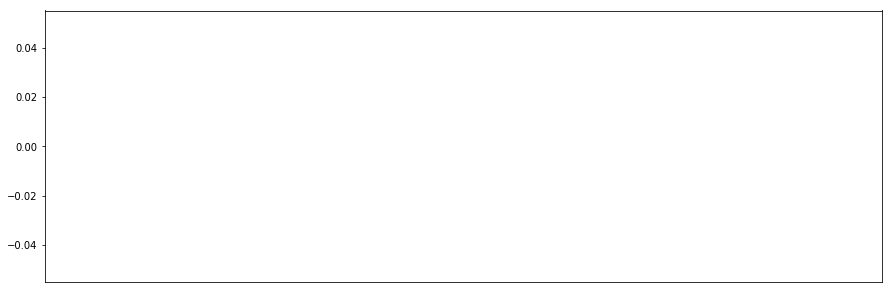

In [10]:
# count missing values for each task
data = collections.Counter([x[1] for x in missing]).values()
names = list(collections.Counter([x[1] for x in missing]).keys())

# create barplot
figure = plt.figure(figsize=(15,5))
plt.bar(x = range(len(data)), height = data, tick_label = names)



## Iterate through missing runs in linear fashion

In [315]:
# create empty variable
last = np.nan

# loop over tasks
for i in missing:
    try: 
        # get task if not previously loaded
        if i[1] != last: 
            print('Load task', i[1])
            task = openml.tasks.get_task(i[1])
        else:
            print('Task already loaded...')     

        # save last task 
        last = i[1]

        # initialize model with parameters from run
        print('Load model', i[0])
        model = openml.setups.initialize_model(i[0])

        # run best model on the task
        print('Run model...')
        run = openml.runs.run_model_on_task(model, task)

        # print feedbackack
        print('Publish openml run...')

        # publish the run 
        run.publish()

    except Exception as e:
        print(e)
        continue
  

Load task 6
Load model 8155685
Run model...
Publish openml run...
Task already loaded...
Load model 8155791
Run model...
Publish openml run...
Task already loaded...
Load model 8155803
Run model...
Publish openml run...
Task already loaded...
Load model 8155954
Run model...
Publish openml run...
Task already loaded...
Load model 8155990
Run model...
Publish openml run...
Task already loaded...
Load model 8156025
Run model...
Publish openml run...
Task already loaded...
Load model 8156305
Run model...
Publish openml run...
Task already loaded...
Load model 8156320
Run model...
Publish openml run...
Task already loaded...
Load model 8156361
Run model...
Publish openml run...
Task already loaded...
Load model 8156374
Run model...
Publish openml run...
Task already loaded...
Load model 8156445
Run model...
Publish openml run...
Task already loaded...
Load model 8156614
Run model...
Publish openml run...
Task already loaded...
Load model 8156755
Run model...
Publish openml run...
Task alrea

## Iterate through missing runs in random order

In [316]:
random.shuffle(missing)

# loop over tasks
for i in missing:
    try: 
        # get task   
        print('Load task', i[1])
        task = openml.tasks.get_task(i[1])

        # initialize model with parameters from run
        print('Load model', i[0])
        model = openml.setups.initialize_model(i[0])

        # run best model on the task
        print('Run model...')
        run = openml.runs.run_model_on_task(model, task)

        # print feedbackack
        print('Publish openml run...')

        # publish the run 
        run.publish()

    except Exception as e:
        print(e)
        continue
  

Load task 6
Load model 8168921
Run model...
One or more runs of this setup were already performed on the task.
Load task 6
Load model 8168931
Run model...
One or more runs of this setup were already performed on the task.
Load task 6
Load model 8156614
Run model...
One or more runs of this setup were already performed on the task.
Load task 6
Load model 8157808
Run model...
One or more runs of this setup were already performed on the task.
Load task 6
Load model 8166936
Run model...
One or more runs of this setup were already performed on the task.
Load task 6
Load model 8157494
Run model...
One or more runs of this setup were already performed on the task.
Load task 6
Load model 8157436
Run model...
One or more runs of this setup were already performed on the task.
Load task 6
Load model 8167778
Run model...
One or more runs of this setup were already performed on the task.
Load task 6
Load model 8156374
Run model...
One or more runs of this setup were already performed on the task.
L